In [1]:
# Voeg imports toe als je ze nodig hebt
import random
import torch.nn as nn
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import ToTensor
import torch
import torchvision.io as tio
import matplotlib.pyplot as plt
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")
%matplotlib inline
from torchensemble.utils.logging import set_logger

Using cuda device


In [2]:
# hyperparameters
mylearnrate = 1e-4
batchsize = 16
mymomentum = 0.9
epochs = 300
optchoice = 'adamw'
generator1 = torch.Generator().manual_seed(42)
inputdata = 'original_augm_cropped' 
test_batchsize = 16 #total pictures in test

### TRYING TO GENERALIZE SO THE VAL LOSS DROPS
resizevalue = 224 
dropout = 0.2 # added extra linear layer to resnet with dropout, transformers model has p = 0 standard, this will change that value
noise_factor = random.uniform(0, 0.4) # transformer noise 
myweight_decay=0.01  ##optimizer sgd parameter 
# L2 regularization, which is the sum of squares of all weights in the model, 
# and L1 regularization, which is the sum of the absolute values of all weights in the model.
# Both of them are scaled by a (small) factor, which is a hyperparameter we set prior to training.
# Typically, the parameter for weight decay is set on a logarithmic scale between 0 (overfitting) and 0.1(underftting) 
# (0.1, 0.01, 0.001, ...)
##############################################

In [3]:
if inputdata == 'apple_cropped_r224_augm':
    dataset_path = "./apple_cropped_r224_augm"
elif inputdata == 'resized224':
    dataset_path = './apple_resized_224/Train'
elif inputdata == 'resized224_augm':
    dataset_path = './apple_resized_224_augm/Train'
elif inputdata == 'original_augm':
    dataset_path = './apple_original_augm/Train'
elif inputdata == 'original_augm_cropped':
    dataset_path = './apple_original_augm_cropped/'


print(dataset_path)

./apple_original_augm_cropped/


In [4]:
# get length of each folder in imagefolder dataset
import os
imagefolder = dataset_path
for folder in os.listdir(imagefolder):
    print(folder, len(os.listdir(os.path.join(imagefolder, folder))))

Blotch_Apple 75
Normal_Apple 77
Rot_Apple 102
Scab_Apple 59


Transformer Choice


In [5]:
#Swin Transformer: image classification, 87.3 top-1 accuracy on ImageNet-1
#https://pytorch.org/vision/main/models.html
transformersmodel = torch.hub.load(
    "pytorch/vision", "vit_b_16", weights="IMAGENET1K_V1") #85% swin_t | 84% swin_v2_t  | 85% vit_b_16
    #"pytorch/vision", "swin_t", weights="IMAGENET1K_V1") #85% swin_t | 84% swin_v2_t  | 85% vit_b_16
    #"pytorch/vision", "swin_v2_t", weights="IMAGENET1K_V1") #85% swin_t | 84% swin_v2_t  | 85% vit_b_16

Using cache found in C:\Users\tinke/.cache\torch\hub\pytorch_vision_main


In [6]:

#If our dataset is more similar to ImageNet dataset, we can use ImageNet mean and std. 
#ImageNet mean and std are mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]

from torchvision import transforms

# https://towardsdatascience.com/data-augmentations-in-torchvision-5d56d70c372e
transform_img_normal = transforms.Compose([
    #resize before to tensor  Resizing tensors using interpolation would alter the pixel values and introduce artifacts or distortions that may not accurately represent the original image.
    transforms.Resize([resizevalue ,resizevalue ]),
    transforms.ToTensor(), 
    transforms.Normalize(mean = [0.6453, 0.4631, 0.3085],
                          std= [0.2000, 0.2238, 0.2254]),
    #transforms.Grayscale(3) #expected is 3 channels for the model, r == g == b
])

dataset = ImageFolder(dataset_path, transform=transform_img_normal)

    # 'degrees': (1, 0.0, 45.0),  # image rotation (+/- deg)
    # 'translate': (1, 0.0, 0.9),  # image translation (+/- fraction)
    # 'scale': (1, 0.0, 0.9),  # image scale (+/- gain)
    # 'shear': (1, 0.0, 10.0),  # image shear (+/- deg)
    # 'perspective': (0, 0.0, 0.001),  # image perspective (+/- fraction), range 0-0.001
    # 'flipud': (1, 0.0, 1.0),  # image flip up-down (probability)
    # 'fliplr': (0, 0.0, 1.0),  # image flip left-right (probability)


In [7]:
dataset.class_to_idx

{'Blotch_Apple': 0, 'Normal_Apple': 1, 'Rot_Apple': 2, 'Scab_Apple': 3}

In [8]:
# split in train and test
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size],generator=generator1)

In [9]:
#The data loader will apply the composed transform to the images as they are loaded and returned as batches 
# during training or evaluation. This allows you to perform data augmentation or other preprocessing steps on-the-fly 
# as the data is loaded, which is especially useful for training deep learning models.

trainloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batchsize, shuffle=True, num_workers=0)  # numworkers parallel/subprocesses
testloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batchsize, shuffle=False)  # no need to shuffle when evaluating


In [10]:
transform = transforms.Compose([
    #transforms.RandomCrop(224,224),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    #adding noise because the train-loss was going down but the val-loss didnt = overfitting, need to regularize (dropout, more data, noise)
    transforms.Lambda(lambda x: x + torch.randn(x.size()) * noise_factor), 
    transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
    #normalizing after adding noise
    transforms.Normalize(mean = [0.6453, 0.4631, 0.3085],
                          std= [0.2000, 0.2238, 0.2254]),
])

trainloader.dataset.transform = transform
testloader.dataset.transform = transform

In [11]:
transformersmodel.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [12]:
#in_features = transformersmodel.head.in_features #for transformer swin_t
in_features = transformersmodel.heads.head.in_features  #for vision transformer vit16
print(in_features)

768


In [13]:
# Here the size of each output sample is set to 4
#transformersmodel.heads = nn.Linear(in_features, 4)
transformersmodel.heads.head = nn.Linear(in_features, 4) #vit16

#set dropout rate in the entire model
for name, layer in transformersmodel.named_modules():
    if isinstance(layer, nn.Dropout):
         layer.p = dropout

In [14]:
transformersmodel.eval()

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
  (encoder): Encoder(
    (dropout): Dropout(p=0.2, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.2, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.2, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.2, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_a

In [15]:
# load to CUDA
transformersmodel1 = transformersmodel.to(device)

In [16]:
import torch.optim as optim
CrossEntropyLossCriterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(myresnetmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
if optchoice == 'adam':
    optimizer = optim.Adam(transformersmodel.parameters(), lr=mylearnrate)
    print('optimizer = Adam')
elif optchoice  == 'sgd':
    optimizer = optim.SGD(transformersmodel.parameters(), lr=mylearnrate, momentum=mymomentum, weight_decay=myweight_decay)
    print('optimizer = sgd')
elif optchoice  == 'rmsprop':
    optimizer = optim.RMSprop(transformersmodel.parameters(), lr=mylearnrate, momentum=mymomentum)
    print('optimizer = rmsprop')
elif optchoice == 'adamw':
    optimizer = optim.AdamW(transformersmodel.parameters(), lr=mylearnrate, weight_decay=myweight_decay)

<Figure size 640x480 with 0 Axes>

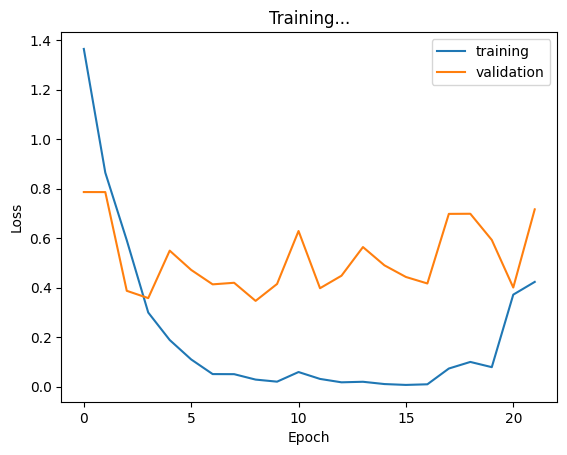

10
Early stopping


In [17]:
# Train function

import realtime_graph as graph
import gc

epochresults = []
epoch_valloss = 0 
correct = 0
total = 0
overfitting_going_up  = 0
graph.startplot()


for epoch in range(epochs):
    
    running_loss = 0.0
    running_valloss = 0.0

    transformersmodel1.train()
    for idx, data in enumerate(trainloader):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = transformersmodel1.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)

    transformersmodel1.eval() # prep model for evaluation
    epoch_vallos_previous = epoch_valloss

    with torch.no_grad():

        for idx, data in enumerate(testloader):

            inputs, labels = data
            #---load data into GPU----
            inputs = inputs.to(device)
            labels = labels.to(device)

            #forward pass
            outputs = transformersmodel1.forward(inputs)
            loss = CrossEntropyLossCriterion(outputs, labels)

            # record validation loss
            running_valloss += loss.item()

            # count correct predictions
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        

        epoch_valloss = running_valloss / len(testloader)


    epochresults.append([epoch_loss, epoch_valloss])

    
    graph.realtimeplot(epochresults)
    
    if epoch_valloss >= epoch_vallos_previous:
        overfitting_going_up += 1
        print(overfitting_going_up)
   
    if overfitting_going_up == 4:
        print("Early stopping")
        stopping_epoch = epoch
        break

In [18]:
transform = transforms.Compose([
    #transforms.RandomCrop(224,224),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(180),
    #adding noise because the train-loss was going down but the val-loss didnt = overfitting, need to regularize (dropout, more data, noise)
    transforms.Lambda(lambda x: x + torch.randn(x.size()) * noise_factor), 
    transforms.RandomResizedCrop(size=224, scale=(0.08, 1.0)),
    #normalizing after adding noise
    transforms.Normalize(mean = [0.6453, 0.4631, 0.3085],
                          std= [0.2000, 0.2238, 0.2254]),
])


In [19]:
trainloader2 = torch.utils.data.DataLoader(
    dataset, batch_size=batchsize, shuffle=True, num_workers=0) 

trainloader2.dataset.transform = transform
print(trainloader2)
# load to CUDA
transformersmodel2 = transformersmodel.to(device)

In [20]:
type(trainloader2)

torch.utils.data.dataloader.DataLoader

<Figure size 640x480 with 0 Axes>

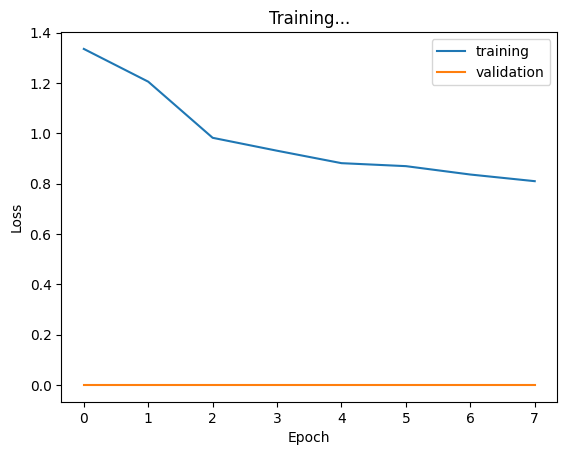

KeyboardInterrupt: 

In [21]:
# Train function

import realtime_graph as graph
import gc

epochresults = []
epoch_valloss = 0 
correct = 0
total = 0
overfitting_going_up  = 0
graph.startplot()


for epoch in range(stopping_epoch):
    
    running_loss = 0.0
    running_valloss = 0.0

    transformersmodel2.train()
    for idx, data in enumerate(trainloader2):
        inputs, labels = data
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        #---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        #-------------------------
        
        #forward pass
        outputs = transformersmodel1.forward(inputs)
        loss = CrossEntropyLossCriterion(outputs, labels)

        optimizer.zero_grad()  # reset previous calculated loss gradients to zero
        loss.backward() # calculate new loss gradient

        optimizer.step() # update weights based on learning rate and gradients
        running_loss += loss.item()

    epoch_loss = running_loss / len(trainloader)
    epoch_vallos_previous = epoch_valloss

    epochresults.append([epoch_loss, 0])
    graph.realtimeplot(epochresults)
    

In [ ]:
dataset_path_test = "D:/apple_disease_classification/Test/"
transform_img_normal = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize([resizevalue ,resizevalue]),
    transforms.Normalize(mean = [0.6453, 0.4631, 0.3085],
                          std= [0.2000, 0.2238, 0.2254]),
])
dataset_test = ImageFolder(dataset_path_test, transform=transform_img_normal)
dataset_test_loader = torch.utils.data.DataLoader(
    dataset_test, batch_size=test_batchsize, shuffle=False)

In [ ]:
# Get the length of the data in dataset_test_loader
num_images = len(dataset_test_loader.dataset)
print(f"Number of images: {num_images}")

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np


correct = 0
total = 0
confusion_matrix = np.zeros((4, 4))  # Initialize the confusion matrix

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    #for idx, data in enumerate(dataset_test_loader):
    for data in dataset_test_loader:
        inputs, labels = data
        
        # print(inputs.shape) = torch.Size([4, 3, 32, 32])

        # ---load data into GPU----
        inputs = inputs.to(device)
        labels = labels.to(device)
        # -------------------------

        # calculate outputs by running images through the network
        outputs =transformersmodel2.forward(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

            
        # Update confusion matrix
        for i in range(len(labels)):
            confusion_matrix[predicted[i]][labels[i]] += 1


print(f'Accuracy of the network on the test images: {100 * correct // total} %')
print('Confusion Matrix:')
print(confusion_matrix)
print(total)

In [ ]:
#precision = TP / TP + FP = 18 / (18+1) = 18/19 actual % normal apples of all the predicted normal apples (19) 
precision = confusion_matrix[1][1] / sum(confusion_matrix[1])
print(f'normal apple correctly predicted/precision:',precision)
#recall = TP / TP + FN = 18 / (18+4+2) = 18/26 correctly identifying actual normal apples (26)
column_sum = sum(row[1] for row in confusion_matrix)
recall = confusion_matrix[1][1]/column_sum
print(f'identifying normal apples/recall',recall)
F1score = 2 / (1/recall + 1/precision)
print(f'F1score:',F1score)

In [ ]:
width, height = confusion_matrix.shape
normtotal = 0
normcorrect = confusion_matrix[1][1]
for i in range(height):
    normtotal += confusion_matrix[i][1]

accuracy_normal_apple = round((normcorrect/normtotal)*100, 1)

print('Accuracy on Normal Apples:'+str(accuracy_normal_apple)+'%')

In [ ]:
# Define class labels
class_labels = ['Blotch', 'Normal', 'Rot', 'Scab']

# Create a figure and axis
fig, ax = plt.subplots()

# Plot the confusion matrix as an image
im = ax.imshow(confusion_matrix, cmap='Blues')

# Add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set the axis ticks and labels
ax.set_xticks(np.arange(len(class_labels)))
ax.set_yticks(np.arange(len(class_labels)))
ax.set_xticklabels(class_labels, fontsize=10)
ax.set_yticklabels(class_labels, fontsize=10)

# Rotate the x-axis labels
plt.setp(ax.get_xticklabels(), rotation=0, ha="center",
         rotation_mode="anchor")

# Rotate the y-axis labels
plt.setp(ax.get_yticklabels(), rotation=90, ha="center",
         rotation_mode="anchor")


# Loop over data dimensions and create text annotations
for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text = ax.text(j, i, confusion_matrix[i, j],
                       ha="center", va="center", color="black")

# Set the title
ax.set_title("Confusion Matrix: 120 Samples")

# Display axis meaning
ax.text(0.5, -0.15, f"True Class", transform=ax.transAxes,
        fontsize=12, ha='center')
ax.text(-0.15, 0.3, f"Predicted Class", rotation=90, transform=ax.transAxes,
        fontsize=12, ha='center')


# Show the figure
plt.tight_layout()
plt.show()


In [ ]:

torch.save(transformersmodel, 'apple_vit_classifier.pt')